# Neural Style Transfer

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from PIL import Image

from os.path import join

import torch
import torch.nn as nn
import torchvision
from torch import optim
from torchvision import transforms as tf
from torch.utils.data import DataLoader

from datasets import CachedDataset, MyDataset
from networks import AdaIN, EncoderVGG, Decoder
from loss import calculate_content_loss, calculate_style_loss

from utils import load_image
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
print("TEST AWS")

TEST AWS


In [3]:
torch.backends.cudnn.benchmark = True
# torch.set_num_threads(1)

In [4]:
content_img_path = 'C:/Users/Stefan/Desktop/Treca Godina/ORI/Image Captioning/ORI_ML/mscoco/train/img'
style_img_path = 'data/wikiart'

In [5]:
content_test_folder = 'images/input/content'
style_test_folder = 'images/input/style'

In [6]:
img_limit = 25000
cache_size = 11000
batch_size = 8 
num_epochs = 20

## Define Transforms

In [7]:
############################################# 512 ##################################
transform = tf.Compose([
    tf.Resize(512),
    tf.RandomResizedCrop(256),
    tf.ToTensor()
])

In [8]:
test_transform = tf.Compose([
#     tf.Resize(1024),
    tf.ToTensor(), 
#     tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # normalize to Gaussian(0,1)
])

test_inverse = tf.Compose([
    tf.ToPILImage()
])

In [9]:
content_dataset = MyDataset(content_img_path, transform, img_limit)
style_dataset = MyDataset(style_img_path, transform, img_limit)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Stefan/Desktop/Treca Godina/ORI/Image Captioning/ORI_ML/mscoco/train/img'

In [9]:
len(content_dataset.img_names)

25000

In [10]:
content_loader = DataLoader(content_dataset, batch_size, num_workers=3, shuffle=True)
style_loader = DataLoader(style_dataset, batch_size, num_workers=3, shuffle=True)

## Initialize networks

In [11]:
torch.cuda.empty_cache()

# encoder = EncoderVGG()
encoder = EncoderVGG().to(device)
for net in encoder.subnets:
    net = net.to(device)

adain = AdaIN().to(device)
decoder = Decoder(encoder).to(device)

In [16]:
# decoder.load_state_dict(torch.load('saved_models/second_11000_25style.pt'))

<All keys matched successfully>

## Optimizer

In [17]:
lr =  5e-5 #1e-4
lr_decay = 5e-5
optimizer = optim.Adam(decoder.parameters(), lr=lr) # 
criterion = nn.MSELoss()
c_weight = 1
s_weight = 25

## Training

In [18]:
def test(c_img, s_img, clamp=True):
    torch.cuda.empty_cache()
    encoder.eval()
    decoder.eval()
    
    c_img = c_img.unsqueeze(0)
    s_img = s_img.unsqueeze(0)

    encoded_style_test = encoder(s_img)
    encoded_content_test = encoder(c_img)[-1]

    adain_out_test = adain(encoded_content_test, encoded_style_test[-1])

    out_img = decoder(adain_out_test).cpu().squeeze(0)
    if clamp:
        out_img = torch.clamp(out_img, -1, 1)
    return test_inverse(out_img)

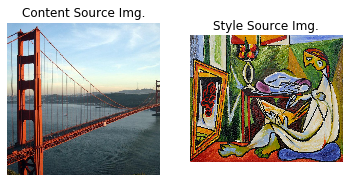

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [19]:
fixed_c_path = join(content_test_folder, 'golden_gate.jpg')
fixed_s_path = join(style_test_folder, 'la_muse.jpg')

fixed_c_img = test_transform(load_image(fixed_c_path)).to(device)
fixed_s_img = test_transform(load_image(fixed_s_path)).to(device)

f, axarr = plt.subplots(1,2)
axarr[0].axis('off')
axarr[1].axis('off')
axarr[0].set_title('Content Source Img.')
axarr[1].set_title('Style Source Img.')
axarr[0].imshow(test_inverse(fixed_c_img.cpu()))
axarr[1].imshow(test_inverse(fixed_s_img.cpu()))
plt.show()
plt.figure()

In [20]:
def train_step(content_batch, style_batch):
    optimizer.zero_grad()
    
    encoded_style = encoder(style_batch)
    encoded_content = encoder(content_batch)[-1]
    
    adain_out = adain(encoded_content, encoded_style[-1])
    
    out_img_batch = decoder(adain_out)
    
    encoded_out_batch = encoder(out_img_batch)
    
    content_loss = calculate_content_loss(encoded_out_batch[-1], adain_out, criterion)
    style_loss = calculate_style_loss(encoded_out_batch, encoded_style, criterion)
    loss = s_weight * style_loss + c_weight * content_loss
    loss.backward()
    optimizer.step()
    return loss


def adjust_learning_rate(optimizer, epoch):
    new_lr = lr / (1.0 + lr_decay * epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    return new_lr

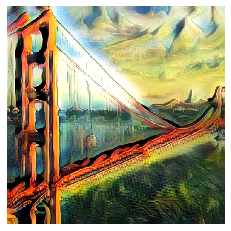

Epoch 0 Loss 16.328819860839843 Learning Rate 5e-05
Time taken for epoch 1336.113679409027 sec



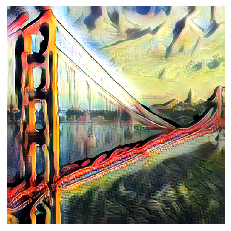

Epoch 1 Loss 16.008007226867676 Learning Rate 4.999750012499375e-05
Time taken for epoch 1277.6344060897827 sec



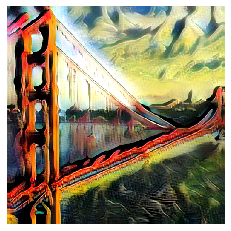

Epoch 2 Loss 15.589270239715576 Learning Rate 4.999500049995001e-05
Time taken for epoch 1272.1082425117493 sec



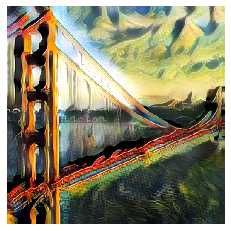

Epoch 3 Loss 15.291366266937256 Learning Rate 4.999250112483127e-05
Time taken for epoch 1283.155198097229 sec



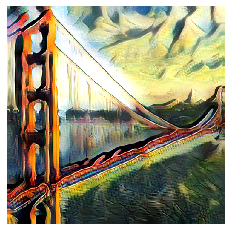

Epoch 4 Loss 14.880266640167237 Learning Rate 4.9990001999600085e-05
Time taken for epoch 1275.8510875701904 sec



In [21]:
import time

def train():
    decoder.train()
    encoder.train()
    
    for epoch in range(5):
        start = time.time()
        total_loss = 0
        steps = 0
        for content_batch, style_batch in zip(content_loader, style_loader):
            content_batch, style_batch = content_batch.to(device), style_batch.to(device)
            total_loss += train_step(content_batch, style_batch).item()
            steps += 1
        
        new_lr = adjust_learning_rate(optimizer, epoch)
        
        if epoch % 1 == 0:
            plt.axis('off')
            new_img = test(fixed_c_img, fixed_s_img)
            plt.imshow(new_img)
            plt.show()
        
        print(f'Epoch {epoch} Loss {total_loss / steps} Learning Rate {new_lr}')
        print(f'Time taken for epoch {time.time() - start} sec\n')

train()    

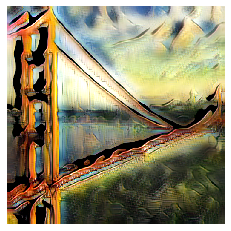

Epoch 0 Loss 19.483299969066273 Learning Rate 5e-05
Time taken for epoch 589.1106994152069 sec



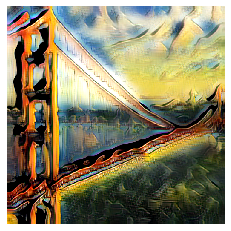

Epoch 1 Loss 18.708018827264958 Learning Rate 4.999750012499375e-05
Time taken for epoch 590.0570330619812 sec



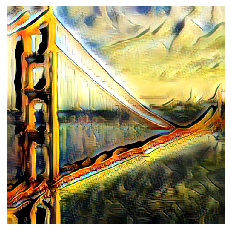

Epoch 2 Loss 18.352392038518733 Learning Rate 4.999500049995001e-05
Time taken for epoch 587.4867401123047 sec



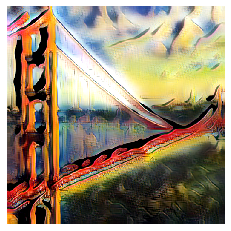

Epoch 3 Loss 17.79353583908081 Learning Rate 4.999250112483127e-05
Time taken for epoch 571.6635341644287 sec



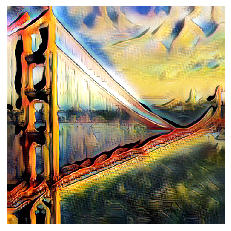

Epoch 4 Loss 17.678087054859507 Learning Rate 4.9990001999600085e-05
Time taken for epoch 566.710488319397 sec



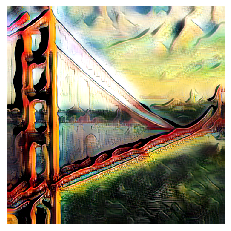

Epoch 5 Loss 16.95945485132391 Learning Rate 4.9987503124218944e-05
Time taken for epoch 608.0339193344116 sec



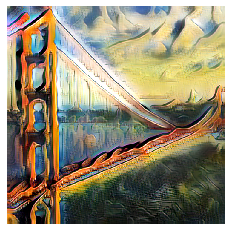

Epoch 6 Loss 16.84453447896784 Learning Rate 4.998500449865041e-05
Time taken for epoch 590.6252465248108 sec



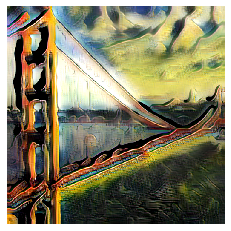

Epoch 7 Loss 16.716472889293325 Learning Rate 4.9982506122857e-05
Time taken for epoch 581.7437136173248 sec



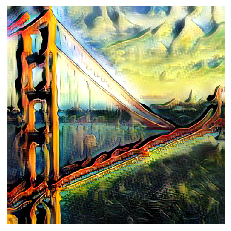

Epoch 8 Loss 16.54180117624456 Learning Rate 4.9980007996801286e-05
Time taken for epoch 584.0373961925507 sec



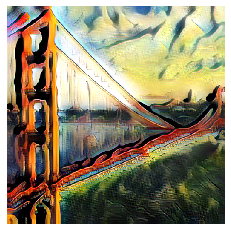

Epoch 9 Loss 16.32763611082597 Learning Rate 4.9977510120445796e-05
Time taken for epoch 572.6636760234833 sec



In [36]:
import time

def train():
    decoder.train()
    encoder.train()
    
    for epoch in range(10):
        start = time.time()
        total_loss = 0
        steps = 0
        for content_batch, style_batch in zip(content_loader, style_loader):
            content_batch, style_batch = content_batch.to(device), style_batch.to(device)
            total_loss += train_step(content_batch, style_batch).item()
            steps += 1
        
        new_lr = adjust_learning_rate(optimizer, epoch)
        
        if epoch % 1 == 0:
            plt.axis('off')
            new_img = test(fixed_c_img, fixed_s_img)
            plt.imshow(new_img)
            plt.show()
        
        print(f'Epoch {epoch} Loss {total_loss / steps} Learning Rate {new_lr}')
        print(f'Time taken for epoch {time.time() - start} sec\n')

train()        

In [22]:
torch.save(decoder.state_dict(), 'saved_models/third_25000_25style.pt')

In [127]:
# torch.save(decoder.state_dict(), 'saved_models/second_11000_25style.pt')

In [87]:
# torch.save(decoder.state_dict(), 'saved_models/first_model_4000_50style.pt')

## Test

In [25]:
content_img = fixed_c_img

In [23]:
style_img = test_transform(load_image(join(style_test_folder, '18299.jpg'))).to(device)

In [22]:
style_dataset.img_names[1824]

'102166.jpg'

626


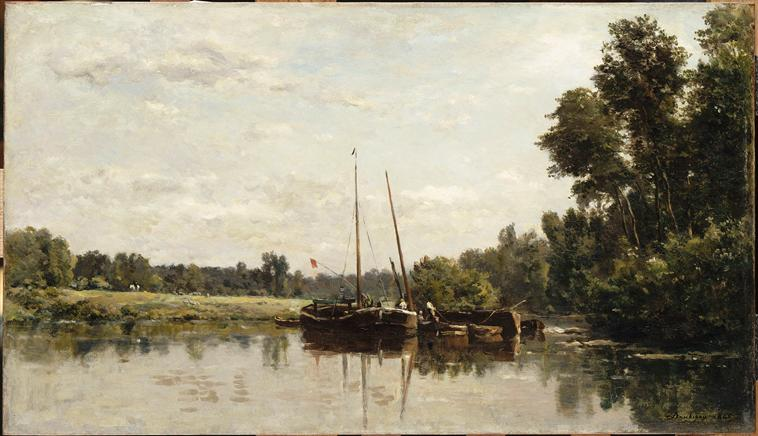

In [290]:
from random import randrange
idx = randrange(img_limit)
print(style_dataset.img_names[idx])
style_img = style_dataset.get_no_transform(idx).to(device)
test_inverse(style_img.cpu())

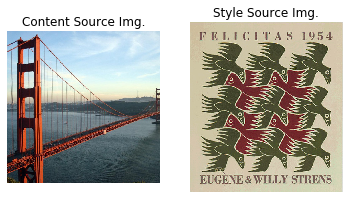

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [26]:
f, axarr = plt.subplots(1,2)
axarr[0].axis('off')
axarr[1].axis('off')
axarr[0].set_title('Content Source Img.')
axarr[1].set_title('Style Source Img.')
axarr[0].imshow(test_inverse(content_img.cpu()))
axarr[1].imshow(test_inverse(style_img.cpu()))
plt.show()
plt.figure()

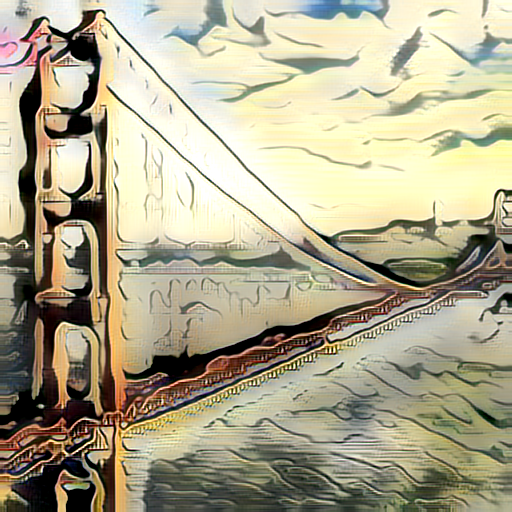

In [27]:
test(content_img, style_img)

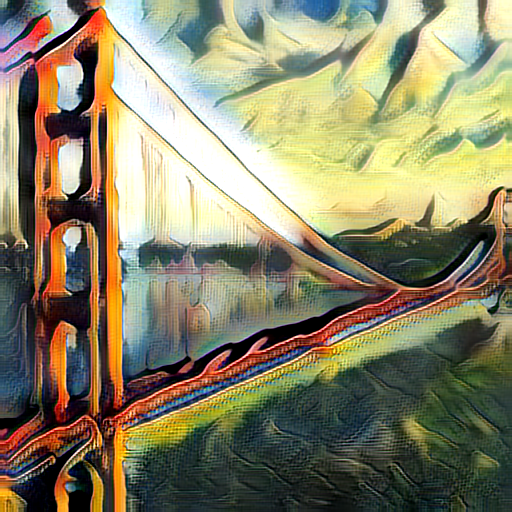

In [28]:
test(fixed_c_img, fixed_s_img) # 25 25000

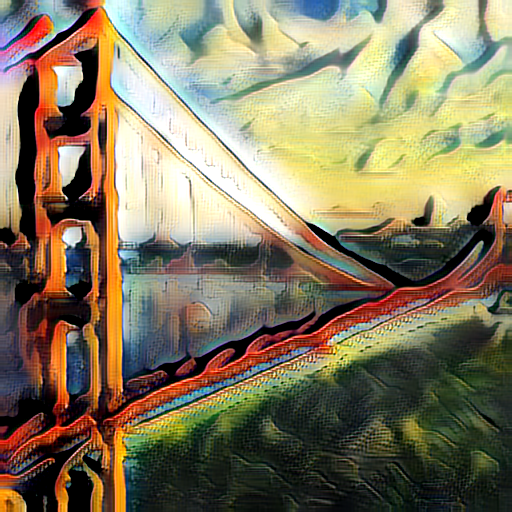

In [135]:
test(fixed_c_img, fixed_s_img) # 25 11000

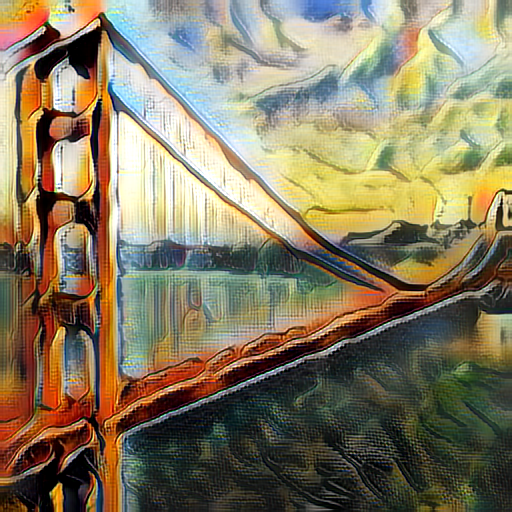

In [32]:
test(fixed_c_img, fixed_s_img) # 100

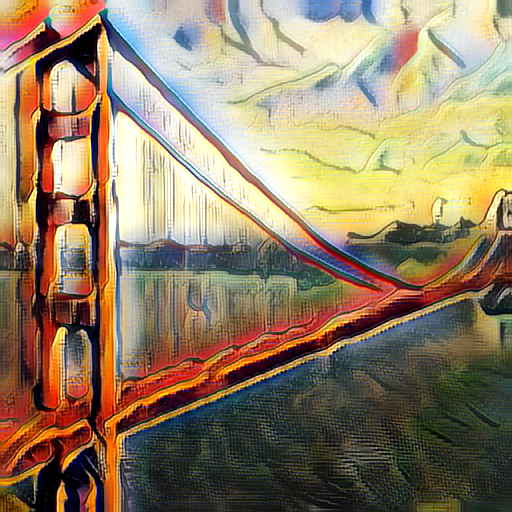

In [19]:
test(fixed_c_img, fixed_s_img) # 25

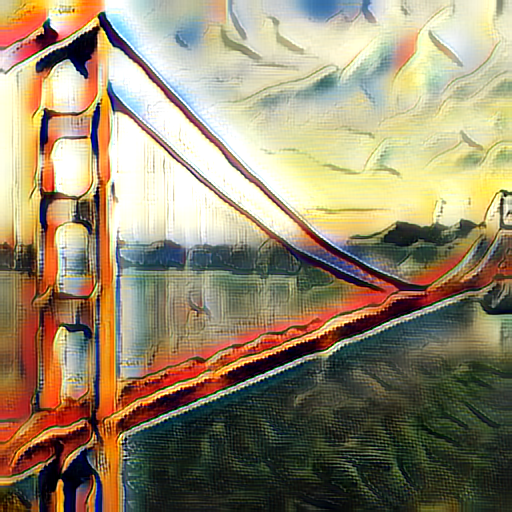

In [21]:
test(fixed_c_img, fixed_s_img) # 50